In [2]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

#additional  modules
import pandas as pd
import numpy.linalg

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.




> *Solution notes*. We want to reconstruct the matrix A and the vector b for the equivalent system
$$Au = b $$
I am assuming the variables `omega` and `bc` will be given as an vectors in the form `[a,b]`



In [8]:
def finDif(omega,f,n,bc):

    stop = omega[1]
    start = omega[0]
    x = linspace (start, stop, n)
    h = (stop - start)/(n-1)

    # construct A
    d2 = ones((n-2,)) # 2nd Offdiagonal entries
    d1 = -16*ones((n-1,)) # 1st Offdiagonal entries
    d = 30*ones((n,)) # Diagonal entries
    
    A = (diag(d2, -2) + diag(d1, -1) + diag(d, 0) + diag(d1, 1) + diag(d2, 2) )
    A /= 12 * (h**2)

    # construct b
    b = f(x)

    # fix boundary conditions
    A[:,0] = 0
    A[0,:] = 0
    A[0,0] = 1
    A[:,-1] = 0
    A[-1,:] = 0
    A[-1,-1] = 1

    b[0]  = bc[0]
    b[-1] = bc[1]

    return A, b

Call the function using:

In [ ]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [72]:
def LU(A):
    B = A.copy()
    N=len(B)
    for k in range(N-1):
        if (abs(B[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
       
        #B[k,k] is the pivot at step k
        # here we are constructing the multipliers which will make up the matrix L    
        B[k+1:N,k] /= B[k,k]

        #here we are constructing the elements of U
        for j in range(k+1,N):
            B[k+1:N,j] -= B[k+1:N,k]*B[k,j]
    
    #define the lower triangular matrix L
    L=tril(B)

    # fix the diagonal of L as 1.
    for i in range(N):
        L[i,i]=1.

    #define the upper triangular matrix B
    U = triu(B)
    return L, U

L, U = LU(A)

> *Solution notes*. To compute the Cholesky factoriziation we need $A$ to be symmetric and definite positive. The matrix $A$ as we have defined it meets these requirements.

In [ ]:
def cholesky(A):
    B = A.copy()
    N = len(B)
    for k in range(N-1):
      #B[k,k] is the pivot at step k
        B[k,k] = sqrt(B[k,k])
        B[k+1:N,k] /= B[k,k]
        
        for j in range(k+1,N):
            B[j:N,j] -= B[j:N,k]*B[j,k]

    #we fix the last row     
    B[-1,-1] = sqrt(B[-1,-1])
    #we define R transposed
    R=tril(B)
    return R, R.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [73]:
#this algorithm will solve the system Lx=rhs, where L is a lower triangular matrix
def L_solve(L,rhs):

    #x will be populated with the solution
    x = zeros_like(rhs)
    N = len(L)

    #the system is solved "top down"    
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [74]:
#this algorithm will solve the system Ux=rhs, where U is a lower triangular matrix
def U_solve(U,rhs):
  
    #x will be populated with the solution
    x = zeros_like(rhs)
    N = len(U)
    
    #the system is solved "bottom up"
    x[N-1] = rhs[N-1]/U[N-1,N-1]
    for i in range(N-2,-1,-1):
        x[i] = (rhs[i] - dot(U[i, i:N], x[i:N]))/U[i,i] 
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:



> *Solution notes.* We solve the two systems:
$$L w =b$$
$$U x = w$$
In this order.



In [ ]:
w = L_solve(L,b)
u = U_solve(U,w)


plot(u,'ro')


Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [70]:
def errorDecay (omega,f,u,n,bc):
  x = linspace (omega[0], omega[1], n)

  # u is the approximate solution
  A, b = finDif(omega, f, n, bc)
  w = L_solve(L,b)
  u_ap = U_solve(U,w)

  #vector of actual solutions
  u_ex = u(x)

  #error
  error = abs (u_ex-u_ap)

  plot(x,error)
  
  #table
  table = pd.DataFrame([x,error], index=['point', 'error']).T
  return table

       point     error
0   0.000000  0.000000
1   0.010101  0.006868
2   0.020202  0.014281
3   0.030303  0.021715
4   0.040404  0.029126
..       ...       ...
95  0.959596  0.029126
96  0.969697  0.021715
97  0.979798  0.014281
98  0.989899  0.006868
99  1.000000  0.000000

[100 rows x 2 columns]


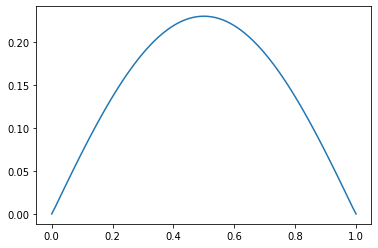

In [75]:
omega = [0,1]
f = lambda x : x*(1-x)
bc = [0,0]
n=100

# u is the actual solution as a function 
u = lambda x : ((x**4)/12) - ((x**3)/6) + (x/12)

print(errorDecay (omega,f,u,n,bc))
x = linspace (omega[0], omega[1], n)

# u is the approximate solution
A, b = finDif(omega, f, n, bc)
w = L_solve(L,b)
u_ap = U_solve(U,w)
#plot(x,u_ap)
#plot(x,u(x))

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.



> *Solution notes*. Since $A$ is symmetric defined positive it's condition number can be computed as
$$K(A)= \frac{\lambda_{max}}{\lambda_{min}}$$
where $\lambda_{max}$ and $\lambda_{min}$ are the biggest and smallest eigenvalues of $A$, respectively.
To compute $\lambda_{max}$ we use the power method and to compute $\lambda_{min}$ we use the inverse power method.





In [65]:

x=linspace(0,1,n)
def l_max(A,x,eps=1e-5,iMax=500):
    l_max = 0
    error = 1 + eps

    i = 0
    while i < iMax and error > eps:
        y = x/numpy.linalg.norm(x,2)

        x = dot(A,y)
        #Rayleigh quotient
        l_max = dot(y.conj().T,x)
        #we define the error 
        error = numpy.linalg.norm(x-l_max*y,2)
        i += 1

    return l_max,y


def l_min(A,x,eps=1e-5,iMax=500):
    A = copy(A)
    L,U = LU(A)
    l_min = 0
    error = 1 + eps

    i = 0
    while i < iMax and error > eps:
        y = x/numpy.linalg.norm(x,2)

        w = L_solve(L,y)
        x= U_solve(U,w)
        #Rayleigh quotient
        l_min = dot(y.conj().T,x)
        #we define the error
        error = numpy.linalg.norm(x-l_min*y,2)
        i += 1

    return l_min,y

In [ ]:
def condNumb(A):
    n=len(A)
    x=linspace(0,1,n)
    
    inv = inverse(A)
    lam_max,x_max = l_max(A,x)
    lam_min,x_min = l_min(A,x)
    condNu = lam_max/lam_min
    return condNu

print(condNumb(A))

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [ ]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
 
  N=len(A)
  L,U = LU(P)

  #set initial conditions for x_0, r_0, p_0, z_0
  #every other vector can be evaluated inside the loop, at i=0 
  x = linspace(0,1,N)

  r = b - dot (A,x)

  z = linalg.solve(P,r)

  p = z

  error = 1. + eps
  i = 0
  while (i<nmax and error> eps):
    
    #we define q=A*p
    q = dot(A,p)
    alpha = dot(p.T,r)/dot(p.T,q)
    x += alpha*p
    r -= alpha*q

    w = L_solve (L,r)
    z = U_solve (U,w)

    beta = dot(q.T,z)/dot(q.T,p)
    p =  z - beta*p
    i += 1
    error = linalg.norm(r,2)

  return x

In [ ]:
x = conjugate_gradient(A,b,identity(len(A)))
print(x)

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$




> *Solution notes*. We want to apply forward Euler to the problem 
$$u'(t)= u_{xx} + \alpha(t)f(x)$$
therefore we want to compute at each step
$$\frac{u(t_{j+1})-u(t_j)}{h} = F(t_i,u_i)$$
where $F(t,x)= u_{xx} + \alpha(t)f(x)$.


> Remember that for $x=x_i$
$$u_{xx}(t,x_i) = \frac{-u_{i-2}(t)+16u_{i-1}(t)-30u_i(t)+16u_{i+1}(t)-u_{i+2}(t)}{12h^2}$$
We can discretize $u$ with respect to $x$ and then substitute $u_{xx}(t_j,x_i)$ in the Forward Euler method:
$$\frac{u_i(t_{j+1})-u_i(t_j)}{h} =F(t_j,x_i) = \frac{-u_{i-2}(t_j)+16u_{i-1}(t_j)-30u_i(t_j)+16u_{i+1}(t_j)-u_{i+2}(t_j)}{12h^2} +  \alpha(t_j)f(x_i)$$
Therefore we can compute the $u_i$ at time step $t_{j+1}$ as:
$$u_i(t_{j+1})= \frac{-u_{i-2}(t_j)+16u_{i-1}(t_j)+(12h-30)u_i(t_j) +16u_{i+1}(t_j)-u_{i+2}(t_j)}{12h}+h\alpha(t_j)f(x_i)$$
We have to compute $u_i$ $\forall i \in {0,\dots,N_x}$, which is equivalent to solving the system $$\mathbf{u}(t_{j+1}) =\tilde A \mathbf{u}(t_{j}) + h \alpha(t_j)\mathbf{f}$$
with $\mathbf{u}(t)=\begin{bmatrix} u_0(t) \\ u_1(t) \\ \vdots \\ u_{N_x}(t) \end{bmatrix} \;$, $\mathbf{f}=\begin{bmatrix} f(x_0) \\ f(x_1) \\ \vdots \\ f(x_{N_x}) \end{bmatrix} \;$ and $\tilde A=I - hA $




In [49]:
#h step size for the varaible t, N number of discretization points for the variable x
def fe(f,omega,bc,alpha,u0,t0,tf,h,N=100):
    timesteps = arange(t0,tf+1e-10, h)
    m=len(timesteps)
    
    # matrix of solutions
    # the vector solution at t=t_i will be on row sol[i]
    sol = numpy.zeros([m, N])

    #f_eval = f(linspace(omega[0], omega[1], n))
    A, b = finDif(omega, f, N, bc)
    A_tilde = numpy.identity(N) - h*A

    #initialize the vector of solutions at t_0
    sol[0] = u0

    for i in range(m-1):
        sol[i+1] =dot(A_tilde,sol[i])+ h*alpha(timesteps[i])*b 
    
    return sol, timesteps




> Remember that $f(x)=sin(x)$, and that $f$ was defined in $\Omega=[0,\pi]$ 



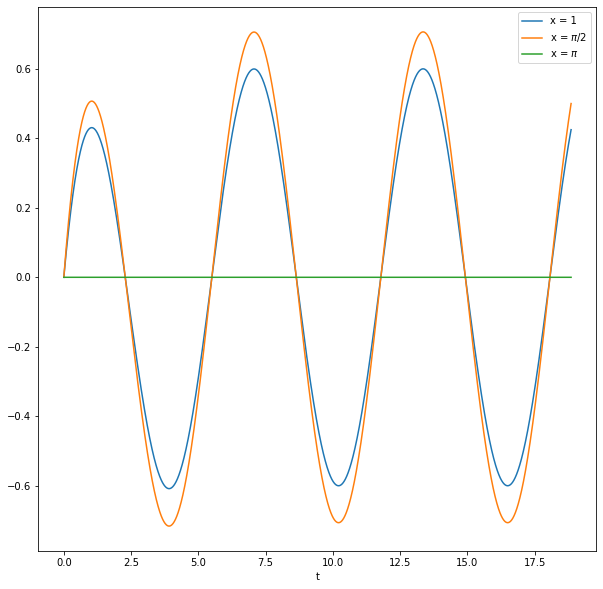

In [69]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]

alpha = lambda t : cos(t)
t0=0
tf=6*pi
u0=zeros((n,))

#we define h as such for stability
A,b=finDif(omega, f, n, bc)
x = linspace(omega[0], omega[1], n)
lam_max, v_max =l_max(A,x)
h=1/lam_max


u, t = fe(f,omega,bc,alpha,u0,t0,tf,h,N=n)


x = linspace(omega[0], omega[1], n)
figure(figsize = [10, 10])
plot(t, u[:, abs(x - 1).argmin()], label = 'x = 1') 
plot(t, u[:, abs(x - pi / 2).argmin()], label = 'x = $\pi/2$') 
plot(t, u[:, abs(x - pi).argmin()], label = 'x = $\pi$')
xlabel('t')
legend()
show()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

> *Solution's notes*. We will implement a funcion `eigen`, which leverages the power method with deflation: using the power method, $\lambda_{max}$ will be computed. Then we will define a new matrix $B = A−\lambda_{max} v_{max} v_{max}^T$, where $v_{max}$ is the normal eigenvalue of $A$ corresponding to the eigenvector $\lambda_{max}$. B behaves like A in all directions but for the direction of $v_{max}$, which becomes zero. Therefore using the power method I can compute $\lambda_{max}$ of $B$, which is the second largest eigenvalue of A. This can be iterated until all eigenvectors have been found.

> Note that this procedure only works if $A$ is symmetrical,because if $A$ is symmetric then it has an orthogonal base of eigenvectors. In our case A is symmetric, therefore we can use this algorithm.



In [ ]:
def eigen(A):
  B=A.copy()
  n=len(B)

  l= numpy.zeros((n,1))
  x = numpy.zeros((n,n))
  z0 =linspace(0,1,n)
  for i in range(n):
    l[i],x[i] = l_max(B,z0,iMax=1500000)
    y = x[i].reshape(1,-1)
    lam=l[i]/dot(y,y.T)
    B = B - lam*dot(y.T,y)
  return l, x

Compute the inverse of the matrix A exploiting the derived LU factorization



> *Solution notes*. To compute $A^{−1}$ we can solve the $n$ systems $$Ax_i=e_i$$
where $x_i$ is the $i$-th column of $A$, and $e_i$ is the $i$-th vector of the canonical base.




In [ ]:

def inverse(A):
  N = len(A)
  x = numpy.zeros(N)
  inv = zeros_like(A)

  A=A.copy()
  L, U = LU(A)


  for i in range(N):
    #We define the vector e_i at each step
    x[i] = 1.
    w = L_solve(L,x)
    inv[:,i] = U_solve(U,w)

    x[i] = 0.
  return inv


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.



> *Solution notes*. I will implement a funcion be where $f'$ is given as an input, as well as $f$. This is to let the method be as general as possible, without sacrificing performance.




In [ ]:
def newton(f, f_prime, t, nMax=500, eps=1e-10):
  k = 0
  x = 1.3
  x0 = 0
  error = eps + 1.
  while (k < nMax and error>eps):
    x0 = x
    x -= f(t,x)/f_prime(t,x)
    error = abs(x-x0)

  return x

In [ ]:
#h is the step size for t 
def be(y0,t0,tf,h):
    timesteps = arange(t0,tf+1e-10, h)
    sol = zeros_like(timesteps)
    sol[0] = y0
    F_prime = lambda t,x : 1 + 2*t*h*x
    for i in range(1,len(sol)):
        F = lambda t,x : x - sol[i-1] + t*h*(x**2)
        sol[i] = newton(F, F_prime, timesteps[i]) 
    
    return sol, timesteps

In [ ]:
sol, timesteps = be(1,0,2,1/40)
plot(sol)
g = lambda t : 2/(2+(t**2))
plot(g(timesteps))
